# Processo de Modelagem

### Objetivo: realizar o treino e teste com a base de dados tratada

#1 - Import das bibliotecas

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

# 2 - Import da base de dados

Para avaliação dos modelos, importamos os dataset salvo após a realização do PCA e retirada das informações do paciente.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sp_1232024_pca_internacao.csv', low_memory=False)
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,VAL_TOT
0,-2.287049,-0.293603,-0.003838,1.733943,-0.829236,0.516609,-0.421734,-1.874250,3.043939,0.269217,-0.702544,1.001307,1090.22
1,-0.818319,-0.739210,-0.319654,-0.525378,-0.342728,-0.804429,0.128447,-0.531975,-0.375543,0.056108,0.554332,0.620156,718.83
2,-2.628554,0.793802,-0.872501,-0.048332,-0.834496,0.191455,2.928145,-1.068594,0.584702,-0.184742,0.007455,0.743448,1276.25
3,-0.830060,-0.959446,-0.219089,-0.191138,-0.036639,-0.344323,-0.347239,-0.787683,-0.062623,0.139796,0.453490,0.893514,308.33
4,-0.594248,-1.123542,-0.092317,-0.415663,0.069698,-0.099866,0.082090,-0.624372,-0.832091,-0.022275,0.570638,0.940778,337.48


In [4]:
df.shape

(241806, 13)

# 3 -Divisão de treino (70%) e teste (30%)

Foi realizado a divisão de treino e teste.

In [5]:
x = df.drop('VAL_TOT', axis=1)
y = df['VAL_TOT']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, shuffle=True
)

print(f"Dados -> Treinamento {len(x_train)} - Teste: {len(x_test)}")
print(f"Target -> Treinamento {len(y_train)} - Teste: {len(y_test)}")

Dados -> Treinamento 169264 - Teste: 72542
Target -> Treinamento 169264 - Teste: 72542


#4 - Modelos

Para comparação dos resultados temos a informação do nosso target para comparação.

In [ ]:
df['VAL_TOT'].describe()

,VAL_TOT
count,241806.000000
mean,1778.416638
std,4672.440800
min,0.000000
25%,356.810000
50%,675.940000
75%,1264.080000
max,213315.770000


**Modelos:**

Linear Regression: Modelo que assume uma relação linear entre as features e a target. Ele ajusta uma linha (ou hiperplano) que melhor representa essa relação, minimizando a soma dos erros quadráticos.

Random Forest: Modelo Cria várias árvores de decisão independentes (com diferentes subconjuntos de dados e features) e faz a média dos resultados (para regressão). Isso reduz o risco de overfitting e melhora a precisão em relação a uma única árvore.

XGBoost Regressor: Modelo Constrói árvores de decisão sequenciais, onde cada nova árvore corrige os erros da anterior. É altamente eficiente, rápido e costuma ter desempenho superior em muitos problemas, além de permitir regularização para evitar overfitting.

**Parâmetro para avaliações dos modelos:**

*   R² Coeficiente de determinação: Mede o quanto da variabilidade da target é explicada pelo modelo
*   MAE (Mean Absolute Error): Mostra a média dos valores absolutos do erro
*   MSE Mean Squared Error: Média dos erros ao quadrado entre valor previsto e o real da variável target
*   RMSE (Root Mean Squared Error): Mostra a média dos erros mas na unidade do target

Também foi função cross_validate() do Scikit-learn que avalia a performance de um modelo usando validação cruzada. Ela divide os dados em vários subconjuntos (folds) e avalia o modelo várias vezes, cada vez usando um fold como validação e os demais como treino.

In [ ]:
models = {
    "Linear Regression": make_pipeline(LinearRegression()),
    "Random Forest": make_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1)),
    "XGBoost": make_pipeline(XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)),
}

scoring = {
    'r2': 'r2',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error',
}

for name, model in models.items():
    scores = cross_validate(model, x_train, y_train, cv=5, scoring=scoring,
                          return_train_score=False, n_jobs=-1)

    r2 = scores['test_r2']
    mae = -scores['test_neg_mae']
    mse = -scores['test_neg_mse']
    rmse = np.sqrt(mse)

    print(f"{name} - R²: {r2.mean():.4f} | MAE: {mae.mean():.4f} | MSE: {mse.mean():.4f}| RMSE: {rmse.mean():.4f}")
    print(f"Detalhes por fold:")
    print(f"R²:    {np.round(r2, 4)}")
    print(f"MAE:   {np.round(mae, 4)}")
    print(f"MSE:   {np.round(mse, 4)}")
    print(f"RMSE:  {np.round(rmse, 4)}\n")


Linear Regression - R²: 0.4874 | MAE: 1228.7077 | MSE: 11201593.6992| RMSE: 3339.4997
Detalhes por fold:
R²:    [0.4648 0.4887 0.5144 0.5033 0.4656]
MAE:   [1226.3075 1231.156  1226.3606 1213.3233 1246.3911]
MSE:   [12973237.4686 10700042.9328  9430284.4798  9955453.7368 12948949.878 ]
RMSE:  [3601.8381 3271.092  3070.8768 3155.2264 3598.4649]
Random Forest - R²: 0.7418 | MAE: 569.4499 | MSE: 5619946.0677| RMSE: 2367.3083
Detalhes por fold:
R²:    [0.7336 0.7439 0.7581 0.7204 0.7532]
MAE:   [573.7247 575.6671 558.8278 556.6827 582.3473]
MSE:   [6457184.3375 5358987.2753 4698217.2996 5604253.7595 5981087.6665]
RMSE:  [2541.099  2314.9487 2167.5372 2367.3305 2445.6262]
XGBoost - R²: 0.7320 | MAE: 667.5603 | MSE: 5843965.3421| RMSE: 2413.3251
Detalhes por fold:
R²:    [0.7217 0.7539 0.7279 0.7289 0.7274]
MAE:   [663.3561 670.8309 658.9365 658.8884 685.7897]
MSE:   [6746919.2209 5149345.0082 5284757.5801 5433493.7158 6605311.1853]
RMSE:  [2597.4832 2269.2168 2298.8601 2330.9856 2570.08  ]


Foi plotado o gráfico entre os valores previstos e os valores reais com separação entre os modelos para avaliação da performance de cada modelo.


Treinando Linear Regression

Treinando Random Forest

Treinando XGBoost


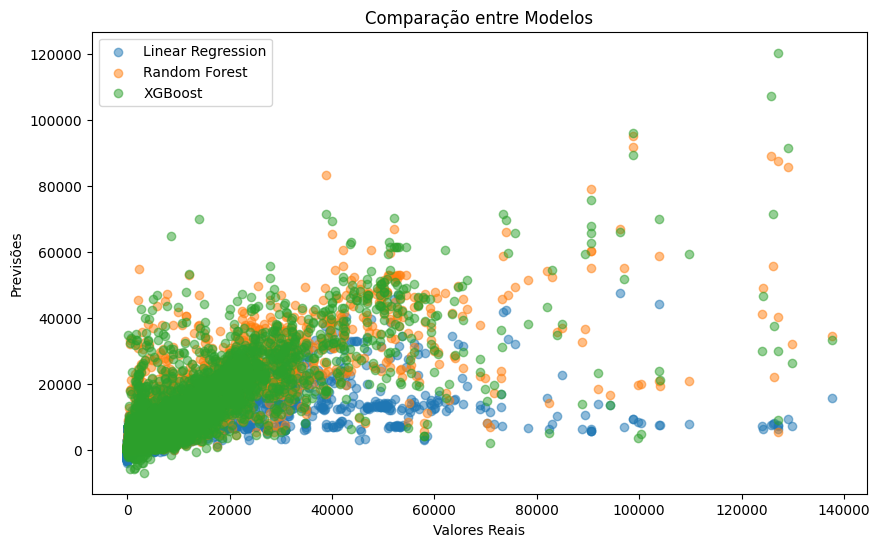

In [ ]:
predictions = {}

for name, model in models.items():
    print(f"\nTreinando {name}")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    predictions[name] = y_pred

plt.figure(figsize=(10, 6))
for name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, label=name, alpha=0.5)

plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.legend()
plt.title("Comparação entre Modelos")
plt.show()

##Teste de hiperparâmetros para modelo Random Forest:



Outra técnica utilizada foi o RandomizedSearchCV() que faz uma busca aleatória sobre uma grade de hiperparâmetros para encontrar a combinação que traz o melhor desempenho para o modelo. Ele faz um número limitado de tentativas, pegando combinações aleatórias.

Hiperparâmetros analizados para o modelo Random Forest:

* randomforestregressor__n_estimators: Número de árvores
* randomforestregressor__max_depth: Profundidade máxima
* randomforestregressor__min_samples_split: Mínimo de amostras para dividir um nó
* randomforestregressor__min_samples_leaf: Mínimo de amostras em uma folha
* randomforestregressor__max_features: Número de features para split

In [ ]:
models = {
    "Linear Regression": make_pipeline(LinearRegression()),
    "Random Forest": make_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1)),
    "XGBoost": make_pipeline(XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)),
}

params_rf = {
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [None, 10, 20, 30],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__min_samples_leaf": [1, 2, 4],
    "randomforestregressor__max_features": ["sqrt", "log2"]
}

search_rf = RandomizedSearchCV(
    models["Random Forest"],
    param_distributions=params_rf,
    n_iter=20,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_rf.fit(x_train, y_train)

print("Melhores hiperparâmetros:", search_rf.best_params_)
print("Melhor score (MSE negativo):", search_rf.best_score_)

best_model_rf = search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Melhores hiperparâmetros: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__max_depth': 30}
Melhor score (MSE negativo): -5787330.385046496


In [ ]:
evaluate_model("Random Forest", y_test, y_pred_rf)


Random Forest
MSE: 5102150.26
RMSE: 2258.79
MAE: 543.70
R²: 0.77


##Teste de hiperparâmetros testados para modelo XGBoost:




Hiperparâmetros analizados para o modelo Random Forest:

* xgbregressor__n_estimators: Numero de árvores de decisão
* xgbregressor__learning_rate: Taxa de aprendizado
* xgbregressor__max_depth: Profundidade da árvore
* xgbregressor__subsample: % de amostras por árvore
* xgbregressor__colsample_bytree: % de features por árvore
* xgbregressor__gamma: Redução mínima de loss para split

In [8]:
models = {
    "Linear Regression": make_pipeline(LinearRegression()),
    "Random Forest": make_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1)),
    "XGBoost": make_pipeline(XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)),
}

params_xgb = {
    "xgbregressor__n_estimators": [100, 200, 300],
    "xgbregressor__learning_rate": [0.01, 0.1, 0.2],
    "xgbregressor__max_depth": [3, 6, 9],
    "xgbregressor__subsample": [0.8, 1.0],
    "xgbregressor__colsample_bytree": [0.8, 1.0],
    "xgbregressor__gamma": [0, 0.1],
}

search_xgb = RandomizedSearchCV(
    models["XGBoost"],
    param_distributions=params_xgb,
    n_iter=20,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_xgb.fit(x_train, y_train)

print("Melhores hiperparâmetros:", search_xgb.best_params_)
print("Melhor score (MSE negativo):", search_xgb.best_score_)

best_model_xgb = search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores hiperparâmetros: {'xgbregressor__subsample': 0.8, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__gamma': 0, 'xgbregressor__colsample_bytree': 0.8}
Melhor score (MSE negativo): -5984980.5011019455


In [9]:
evaluate_model("XGBoost", y_test, y_pred_xgb)


XGBoost
MSE: 5245895.44
RMSE: 2290.39
MAE: 623.97
R²: 0.76


#5 - Conclusão

Somente essas variáveis que foram retiradas não pertenciam ao cluster do target.
Elas foram escolhidas porque são informações do paciente e informaçãoes geradas de maneira aleatória como RUBRICA, SEQ_AIH5 e piorariam o treinamento de ML.

<div align="center">

Variável | Descrição
--- | ---
IDADE | Idade
COD_IDADE | Unidade de medida da idade
NACIONAL | Código da nacionalidade do paciente
NUM_FILHOS | Número de filhos do paciente
INSTRU | Grau de instrução do paciente
CBOR | Ocupação do paciente (Classificação Brasileira de Ocupações – CBO)
CNAER | Código de acidente de trabalho
VINCPREV | Vínculo com a Previdência
CONTRACEP1 | Tipo de contraceptivo utilizado
CONTRACEP2 | Segundo tipo de contraceptivo utilizado
GESTRISCO | Indicador se é gestante de risco
INSC_PN | Número da gestante no pré-natal
IND_VDRL | Indica exame VDRL
CID_NOTIF | CID de Notificação
HOMONIMO | Indicador se o paciente é homônimo de outro
NATUREZA | Natureza jurídica do hospital (com conteúdo até maio/12). Era utilizada a classificação de Regime e Natureza  
NAT_JUR | Natureza jurídica do Estabelecimento, conforme a Comissão Nacional de Classificação - CONCLA  
GESTAO | Indica o tipo de gestão do hospital  
RUBRICA | Zerado  
MUNIC_MOV | Município do Estabelecimento    
NUM_PROC | Zerado  
TOT_PT_SP | Zerado  
CPF_AUT | Zerado  
SEQ_AIH5 | Sequencial de longa permanência (AIH tipo 5)   
GESTOR_COD | Motivo de autorização da AIH pelo Gestor  
GESTOR_TP | Tipo de gestor  
GESTOR_CPF | Número do CPF do Gestor  
GESTOR_DT | Data da autorização dada pelo Gestor (aaaammdd)  
CNPJ_MANT | CNPJ da mantenedora  
INFESHOP | Status de infecção hospitalar  
</div>

#6 - Funções

In [7]:
def evaluate_model(name, y_test, y_pred):
    print(f"\n{name}")
    lin_mse = mean_squared_error(y_test, y_pred)
    print(f"MSE: {lin_mse:.2f}")
    lin_rmse = np.sqrt(lin_mse)
    print(f"RMSE: {lin_rmse:.2f}")
    lin_mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {lin_mae:.2f}")
    r2 = r2_score(y_test, y_pred)
    print(f"R²: {r2:.2f}")